In [1]:
import sys
sys.path.append('../../')

from VectorCGRA.lib.common                  import *
from pymtl3.stdlib.test.test_srcs           import TestSrcRTL
from VectorCGRA.lib.ctrl_helper             import *
from VectorCGRA.fu.flexible.FlexibleFuRTL   import FlexibleFuRTL
from VectorCGRA.fu.single.AdderRTL          import AdderRTL
from VectorCGRA.fu.single.MulRTL            import MulRTL
from VectorCGRA.fu.single.PhiRTL            import PhiRTL
from VectorCGRA.fu.single.CompRTL           import CompRTL
from VectorCGRA.fu.single.BranchRTL         import BranchRTL
from VectorCGRA.fu.single.MemUnitRTL        import MemUnitRTL
from VectorCGRA.fu.single.SelRTL            import SelRTL
from VectorCGRA.fu.single.ShifterRTL        import ShifterRTL
from VectorCGRA.fu.single.LogicRTL          import LogicRTL
from VectorCGRA.fu.single.RetRTL            import RetRTL
from VectorCGRA.fu.double.SeqMulAdderRTL    import SeqMulAdderRTL
from VectorCGRA.cgra.CGRATemplateRTL        import CGRATemplateRTL

from pymtl3.passes import TracingConfigs
from pymtl3.passes.backends.verilog import *
from pymtl3.passes.backends.verilog import TranslationImportPass

In [2]:
import os
import json
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

 ## Compilation

In [3]:
os.getcwd()

'/home/rms/repos/RecoNTT-CGRA/test_build/codes'

In [4]:
!rm -rf ../results/
!mkdir -p ../results/

In [5]:
os.chdir("/home/rms/repos/RecoNTT-CGRA/test_build/codes")

In [6]:
os.getcwd()

'/home/rms/repos/RecoNTT-CGRA/test_build/codes'

In [7]:
!clang-12 -emit-llvm -O3 -fno-unroll-loops -o ../results/kernel.bc -c ../kernels/fir/fir.cpp
!llvm-dis-12 ../results/kernel.bc -o ../results/kernel.ll

In [8]:
irFile = open('../results/kernel.ll', 'r')
irLines = irFile.readlines()
targetKernels = []
for line in irLines:
    if "define " in line and "{" in line and "@" in line:
        funcName = line.split("@")[1].split("(")[0]
        if "main" not in funcName:
            targetKernels.append(funcName)

irFile.close()
print(targetKernels)

['_Z6kernelPfS_S_']


## CGRA definition

In [9]:
fuType2RTL = {}
fuType2RTL["Phi"  ] = PhiRTL
fuType2RTL["Add"  ] = AdderRTL
fuType2RTL["Shift"] = ShifterRTL
fuType2RTL["Ld"   ] = MemUnitRTL
fuType2RTL["St"   ] = MemUnitRTL
fuType2RTL["Sel"  ] = SelRTL
fuType2RTL["Cmp"  ] = CompRTL
fuType2RTL["MAC"  ] = SeqMulAdderRTL
fuType2RTL["Ret"  ] = RetRTL
fuType2RTL["Mul"  ] = MulRTL
fuType2RTL["Logic"] = LogicRTL
fuType2RTL["Br"   ] = BranchRTL

In [10]:
width             = 2
height            = 2
num_tile_inports  = 8
num_tile_outports = 8
num_xbar_inports  = 8
num_xbar_outports = 8
ctrl_mem_size     = 8
data_mem_size     = 8
RouteType         = mk_bits( clog2( num_xbar_inports + 1 ) )
AddrType          = mk_bits( clog2( ctrl_mem_size ) )
num_tiles         = width * height
num_fu_in         = 4
FunctionUnit      = FlexibleFuRTL
FuList           = [ PhiRTL, AdderRTL, ShifterRTL, MemUnitRTL, SelRTL, CompRTL, SeqMulAdderRTL, RetRTL, MulRTL, LogicRTL, BranchRTL ]
DataType          = mk_data( 32, 1 )
PredicateType     = mk_predicate( 1, 1 )
CtrlType          = mk_ctrl( num_fu_in, num_xbar_inports, num_xbar_outports )
FuInType          = mk_bits( clog2( num_fu_in + 1 ) )
pickRegister      = [ FuInType( x+1 ) for x in range( num_fu_in ) ]

DUT = CGRATemplateRTL

In [11]:
targetKernel = '_Z6kernelPfS_S_'

In [12]:
arch = {
  "kernel"                : targetKernel,
  "targetFunction"        : False,
  "targetNested"          : False,
  "targetLoopsID"         : [0],
  "doCGRAMapping"         : True,
  "row"                   : height,
  "column"                : width,
  "precisionAware"        : False,
  "heterogeneity"         : False,
  "isTrimmedDemo"         : True,
  "heuristicMapping"      : True,
  "parameterizableCGRA"   : False,
  "diagonalVectorization" : False,
  "bypassConstraint"      : 4,
  "isStaticElasticCGRA"   : False,
  "ctrlMemConstraint"     : ctrl_mem_size,
  "regConstraint"         : 8
}


In [13]:
# Remember the original working directory
orig_dir = os.getcwd()

# Change to your desired directory
os.chdir("../results/")

In [14]:
os.getcwd()

'/home/rms/repos/RecoNTT-CGRA/test_build/results'

In [15]:
paramCGRAJsonObject = json.dumps(arch, indent=4)
# Writing to param.json
with open('param.json', "w") as outfile:
    outfile.write(paramCGRAJsonObject)


## Mapping

In [16]:
os.getcwd()

'/home/rms/repos/RecoNTT-CGRA/test_build/results'

In [17]:


# make sure you have the correct location of the mapper in the following line
!opt-12 -load ../../CGRA-Mapper/build/src/libmapperPass.so -mapperPass ../results/kernel.bc


This is inadvisable as it may cause display problems. If
you REALLY want to taste LLVM bitcode first-hand, you
can force output with the `-f' option.

Initialize opt latency for DFG nodes: 
Initialize additional functionality on CGRA nodes: 
[function 'main' is not in our target list]
Initialize opt latency for DFG nodes: 
Initialize additional functionality on CGRA nodes: 
[function '_Z6kernelPfS_S_' is one of our targets]
*** reach target loop ID: 0
... done detected loops.size(): 1
*** current function: _Z6kernelPfS_S_
*** current basic block:   %4 = load float, float* %1, align 4, !tbaa !2
   ****** succ bb:   %6 = phi float [ %4, %3 ], [ %13, %5 ]
  %4 = load float, float* %1, align 4, !tbaa !2 *** ignored by pass due to that the BB is out of the scope (target loop)
  br label %5 *** ignored by pass due to that the BB is out of the scope (target loop)
*** current basic block:   %6 = phi float [ %4, %3 ], [ %13, %5 ]
   ****** succ bb:   ret void
   ****** succ bb:   %6 = phi float

## view the dfg

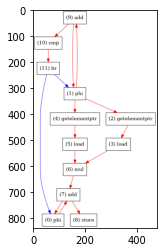

In [18]:
!dot -Tpng ../results/_Z6kernelPfS_S_.dot -o ../results/kernel.png
pil_im = Image.open('kernel.png')
im_array = np.asarray(pil_im)
plt.imshow(im_array)
plt.show()

## Generate the configuration file from the map

In [19]:
target_json = "config.json"
script_dir  = os.path.abspath("")
file_path   = os.path.join( script_dir,target_json )

In [20]:
II                = 4 # set the II value from before

In [36]:
cgra_ctrl         = CGRACtrl( file_path, CtrlType, RouteType, width, height,
                                num_fu_in, num_xbar_inports, num_xbar_outports, II)

In [37]:
src_opt           = cgra_ctrl.get_ctrl()

In [46]:
II

4

In [38]:
src_opt

[[CGRAConfig_6_4_8_8(Bits6(0x01),Bits1(0x0),[Bits3(0x0), Bits3(0x0), Bits3(0x0), Bits3(0x0)],[Bits4(0x0), Bits4(0x0), Bits4(0x0), Bits4(0x0), Bits4(0x4), Bits4(0x0), Bits4(0x0), Bits4(0x0)],[Bits1(0x0), Bits1(0x0), Bits1(0x0), Bits1(0x0), Bits1(0x0), Bits1(0x0), Bits1(0x0), Bits1(0x0)]),
  CGRAConfig_6_4_8_8(Bits6(0x19),Bits1(0x0),[Bits3(0x1), Bits3(0x2), Bits3(0x0), Bits3(0x0)],[Bits4(0x5), Bits4(0x0), Bits4(0x0), Bits4(0x0), Bits4(0x4), Bits4(0x1), Bits4(0x0), Bits4(0x0)],[Bits1(0x0), Bits1(0x0), Bits1(0x0), Bits1(0x0), Bits1(0x0), Bits1(0x0), Bits1(0x0), Bits1(0x0)]),
  CGRAConfig_6_4_8_8(Bits6(0x0d),Bits1(0x0),[Bits3(0x1), Bits3(0x2), Bits3(0x0), Bits3(0x0)],[Bits4(0x0), Bits4(0x0), Bits4(0x0), Bits4(0x0), Bits4(0x1), Bits4(0x0), Bits4(0x0), Bits4(0x0)],[Bits1(0x0), Bits1(0x0), Bits1(0x0), Bits1(0x0), Bits1(0x0), Bits1(0x0), Bits1(0x0), Bits1(0x0)]),
  CGRAConfig_6_4_8_8(Bits6(0x07),Bits1(0x0),[Bits3(0x1), Bits3(0x2), Bits3(0x0), Bits3(0x0)],[Bits4(0x0), Bits4(0x0), Bits4(0x0), Bit

## create the test harness

In [24]:
class TestHarness( Component ):

  def construct( s, DUT, FunctionUnit, FuList, DataType, PredicateType,
                 CtrlType, width, height, ctrl_mem_size, data_mem_size,
                 src_opt, ctrl_waddr, tileList, linkList, dataSPM, preload_data = None,
                 preload_const = None  ):

    s.num_tiles = len(tileList)
    AddrType = mk_bits( clog2( ctrl_mem_size ) )

    s.src_opt     = [ TestSrcRTL( CtrlType, src_opt[i] )
                      for i in range( s.num_tiles ) ]
    s.ctrl_waddr  = [ TestSrcRTL( AddrType, ctrl_waddr[i] )
                      for i in range( s.num_tiles ) ]

    s.dut = DUT( DataType, PredicateType, CtrlType, width, height,
                 ctrl_mem_size, data_mem_size, len( src_opt[0] ),
                 FunctionUnit, FuList, tileList, linkList, dataSPM )

    for i in range( s.num_tiles ):
      connect( s.src_opt[i].send,     s.dut.recv_wopt[i]  )
      connect( s.ctrl_waddr[i].send,  s.dut.recv_waddr[i] )

  def done( s ):
    done = True
    for i in range( s.num_tiles  ):
      if not s.src_opt[i].done():
        done = False
        break
    return done

  def line_trace( s ):
    return s.dut.line_trace()

class Tile:
  def __init__( s, dimX, dimY ):
    s.disabled = False
    s.dimX = dimX
    s.dimY = dimY
    s.toMem = False
    s.fromMem = False
    s.invalidOutPorts = set()
    s.invalidInPorts = set()
    for i in range( PORT_DIRECTION_COUNTS ):
      s.invalidOutPorts.add(i)
      s.invalidInPorts.add(i)

  def getInvalidInPorts(s):
    return s.invalidInPorts

  def getInvalidOutPorts(s):
    return s.invalidOutPorts

  def hasToMem(s):
    return s.toMem

  def hasFromMem(s):
    return s.fromMem

  def getIndex( s, tileList ):
    if s.disabled:
      return -1
    index = 0
    for tile in tileList:
      if tile.dimY < s.dimY and not tile.disabled:
        index += 1
      elif tile.dimY == s.dimY and tile.dimX < s.dimX and not tile.disabled:
        index += 1
    return index

class DataSPM:
  def __init__( s, numOfReadPorts, numOfWritePorts ):
    s.numOfReadPorts = numOfReadPorts
    s.numOfWritePorts = numOfWritePorts

  def getNumOfValidReadPorts( s ):
    return s.numOfReadPorts

  def getNumOfValidWritePorts( s ):
    return s.numOfWritePorts

class Link:
  def __init__( s, srcTile, dstTile, srcPort, dstPort ):
    s.srcTile = srcTile
    s.dstTile = dstTile
    s.srcPort = srcPort
    s.dstPort = dstPort
    s.disabled = False
    s.toMem = False
    s.fromMem = False
    s.memPort = -1

  def getMemReadPort(s):
      return s.memPort

  def getMemWritePort(s):
      return s.memPort

  def isToMem(s):
    return s.toMem

  def isFromMem(s):
    return s.fromMem

  def validatePorts( s ):
    if not s.toMem and not s.fromMem:
      s.srcTile.invalidOutPorts.remove(s.srcPort)
      s.dstTile.invalidInPorts.remove(s.dstPort)
    if s.toMem:
      s.srcTile.toMem = True
    if s.fromMem:
      s.dstTile.fromMem = True


In [30]:
def run_sim( test_harness, max_cycles=10 ):
  test_harness.elaborate()
  test_harness.dut.verilog_translate_import = True
  test_harness.dut.config_verilog_import = VerilatorImportConfigs(vl_Wno_list=['UNSIGNED', 'UNOPTFLAT', 'WIDTH', 'WIDTHCONCAT', 'ALWCOMBORDER'],)
                                                                  # vl_trace_filename="test",
                                                                  # vl_trace=True)
  test_harness = TranslationImportPass()(test_harness)
  test_harness.apply( SimulationPass() )
  test_harness.sim_reset()

  # Run simulation
  ncycles = 0
  print()
  print( "{}:{}".format( ncycles, test_harness.line_trace() ))
  while not test_harness.done() and ncycles < max_cycles:
    test_harness.tick()
    ncycles += 1
    print( "{}:{}".format( ncycles, test_harness.line_trace() ))

  # Check timeout
  assert ncycles < max_cycles

  test_harness.tick()
  test_harness.tick()
  test_harness.tick()

In [31]:
tiles = []
links = None

dataSPM = DataSPM(2, 2)
for r in range( 2 ):
    tiles.append([])
    for c in range( 2 ):
        tiles[r].append(Tile(c, r))

links = [ Link(None, None, 0, 0) for _ in range(16) ]

links[0].srcTile = None
links[0].dstTile = tiles[0][0]
links[0].srcPort = 0
links[0].dstPort = PORT_WEST
links[0].fromMem = True
links[0].memPort = 0
links[0].validatePorts()

links[1].srcTile = tiles[0][0]
links[1].dstTile = None
links[1].srcPort = PORT_WEST
links[1].dstPort = 0
links[1].toMem = True
links[1].memPort = 0
links[1].validatePorts()

links[2].srcTile = None
links[2].dstTile = tiles[1][0]
links[2].srcPort = 1
links[2].dstPort = PORT_WEST
links[2].fromMem = True
links[2].memPort = 1
links[2].validatePorts()

links[3].srcTile = tiles[1][0]
links[3].dstTile = None
links[3].srcPort = PORT_WEST
links[3].dstPort = 1
links[3].toMem = True
links[3].memPort = 1
links[3].validatePorts()

links[4].srcTile = tiles[0][0]
links[4].dstTile = tiles[0][1]
links[4].srcPort = PORT_EAST
links[4].dstPort = PORT_WEST
links[4].validatePorts()

links[5].srcTile = tiles[0][1]
links[5].dstTile = tiles[0][0]
links[5].srcPort = PORT_WEST
links[5].dstPort = PORT_EAST
links[5].validatePorts()

links[6].srcTile = tiles[1][0]
links[6].dstTile = tiles[1][1]
links[6].srcPort = PORT_EAST
links[6].dstPort = PORT_WEST
links[6].validatePorts()

links[7].srcTile = tiles[1][1]
links[7].dstTile = tiles[1][0]
links[7].srcPort = PORT_WEST
links[7].dstPort = PORT_EAST
links[7].validatePorts()

links[8].srcTile = tiles[0][0]
links[8].dstTile = tiles[1][0]
links[8].srcPort = PORT_NORTH
links[8].dstPort = PORT_SOUTH
links[8].validatePorts()

links[9].srcTile = tiles[1][0]
links[9].dstTile = tiles[0][0]
links[9].srcPort = PORT_SOUTH
links[9].dstPort = PORT_NORTH
links[9].validatePorts()

links[10].srcTile = tiles[0][1]
links[10].dstTile = tiles[1][1]
links[10].srcPort = PORT_NORTH
links[10].dstPort = PORT_SOUTH
links[10].validatePorts()

links[11].srcTile = tiles[1][1]
links[11].dstTile = tiles[0][1]
links[11].srcPort = PORT_SOUTH
links[11].dstPort = PORT_NORTH
links[11].validatePorts()

links[12].srcTile = tiles[0][0]
links[12].dstTile = tiles[1][1]
links[12].srcPort = PORT_NORTHEAST
links[12].dstPort = PORT_SOUTHWEST
links[12].validatePorts()

links[13].srcTile = tiles[1][1]
links[13].dstTile = tiles[0][0]
links[13].srcPort = PORT_SOUTHWEST
links[13].dstPort = PORT_NORTHEAST
links[13].validatePorts()

links[14].srcTile = tiles[0][1]
links[14].dstTile = tiles[1][0]
links[14].srcPort = PORT_NORTHWEST
links[14].dstPort = PORT_SOUTHEAST
links[14].validatePorts()

links[15].srcTile = tiles[1][0]
links[15].dstTile = tiles[0][1]
links[15].srcPort = PORT_SOUTHEAST
links[15].dstPort = PORT_NORTHWEST
links[15].validatePorts()

def handleReshape( t_tiles ):
    tiles = []
    for row in t_tiles:
        for t in row:
          tiles.append(t)
    return tiles

tiles = handleReshape(tiles)

## Create the data

In [32]:
ctrl_waddr        = [[ AddrType( 0 ), AddrType( 1 ), AddrType( 2 ), AddrType( 3 ),
                         AddrType( 4 ), AddrType( 5 ) ] for _ in range( num_tiles ) ]
preload_data      = [ DataType( 5, 1 ) ] * data_mem_size
preload_const     = []
for _ in range( num_tiles ):
    preload_const.append([])

preload_const[0].append( DataType( 0, 1) )
preload_const[1].append( DataType( 0, 1) )
preload_const[2].append( DataType( 0, 1) )
preload_const[3].append( DataType( 0, 1) )


## Run the simulation

In [33]:
!rm -rf ../results/verilog
!mkdir -p ../results/verilog

# Change to your desired directory
os.chdir("../results/verilog")

In [34]:
th = TestHarness( DUT, FunctionUnit, FuList, DataType, PredicateType,
                    CtrlType, width, height, ctrl_mem_size, data_mem_size,
                    src_opt, ctrl_waddr, tiles, links, dataSPM, preload_data, preload_const  )
run_sim(  th )

In [35]:
# When finished, change back to the original directory
os.chdir(orig_dir)